In [8]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2
%aimport bs_lib.bs_eda
%aimport bs_lib.bs_preprocess_lib

In [9]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import bs_lib.bs_eda as beda
import bs_lib.bs_preprocess_lib as bsp
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

## Liste des modifications

### Avant entrainement
1. Convertir la variable `price` en float64
1. Supprimer les entrées redondantes
1. `price`:
    * Vérifier les valeurs anormales *Z-score*
    * Log pour normaliser la distribution
1. `year`:
    * Supprimer les années excentriques
    * vérifier les voitures avant 2000
1. `mileage`:
    * Traiter la précense d'anomalies dans les valeurs hautes
    * idem valeurs basses
1. `mpg`:
    * Vérifier la validité des valeurs extrêmes, trop basses et trop hautes.
    * Créer une échelle discrète de rendement: bas, moyen, haut
1. `engine_size`
    * Corriger ou supprimer les valeurs 0
    * traiter les valeurs de 6
    * Créer une échelle discrète de taille de moteur: small, large
    * Utiliser un OrdinalEncoder?
1. `transmission`
    * Supprimer les entrées pour lesquelles le mode de transmission est `Other`
1. `fuel_type`
    * Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives

### Dans le pipeline
1. Convertir la variable `mileage` en float64.
1. Ajout de variables indépendantes à faible corrélation linéaire:
    * polynomialeFeature
    * `age` = nombre d'années
    * `mileage` par années
    * `galon` par années
    * `tax` par `mileage`
    * `litre` (`engine_size`) par `mileage`
    * `litre` par `galon` annuel
1. `mpg`:
    * Créer une échelle discrète de rendement: bas, moyen, haut.
    * Déterminer le nombre de cluster pour améliorer la précision.
1. `year`:
    * Créer une échelle discrète pour chaque année.
    * Supprimer `year` si trop forte colinéarité avec `age`
1. `engine_size`
    * Créer une échelle discrète de taille de moteur. Déterminer le nombre de cluster.
    * Utiliser un OrdinalEncoder?
1. `tax`:
    * Créer une échelle discrète de forfait de taxes.
    * Déterminer le nombre de cluster pour améliorer la précision.
1. Variables discrètes
    * Encoder les features. tester OrdinalEncoder et/ou OneHotEncoder?
1. `model`
    * LabelEncoder
    * Suppression du `model` si trop forte colinéarité  entre `brand`et `model`

In [10]:
df = pd.read_csv('dataset/train_set.csv', index_col=0)
df.shape

(74387, 10)

## Préprocessing avant entrainement

### Suppression des entrées redondantes

In [11]:
df.drop_duplicates(inplace = True)
df.shape

(73478, 10)

### Conversion de types

In [14]:
# Pour les variables `mileage` et `price`, convertir les int64 en float64
df['price'] = df['price'].astype(float)
df['mileage'] = df['mileage'].astype(float)

### Marquage des valeurs anormales avec *Z-score*

In [15]:
columns = beda.get_numerical_columns(df)
thresh = 3

# mask of all rows whose value > thresh
def x_or_nan(x):
    if np.abs(zscore(x, nan_policy = 'omit')) > thresh:
        return np.nan
    else:
        return x

outliers = df[columns].apply(lambda x: np.abs(zscore(x, nan_policy = 'omit')) > thresh)
# replace value from outliers by nan
df[outliers] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73478 entries, 3053 to 13349
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         73478 non-null  object 
 1   year          72487 non-null  float64
 2   price         72166 non-null  float64
 3   transmission  73478 non-null  object 
 4   mileage       72245 non-null  float64
 5   fuel_type     73478 non-null  object 
 6   tax           73164 non-null  float64
 7   mpg           73041 non-null  float64
 8   engine_size   72991 non-null  float64
 9   brand         73478 non-null  object 
dtypes: float64(6), object(4)
memory usage: 6.2+ MB


In [14]:
# Year as category
#bins=np.arange(df['year'].min()-1,df['year'].max()+2)
#print(bins)
#df['year_category']=pd.cut(df['year'],bins=bins)

In [15]:
# Créer une échelle discrète de rendement: bas, moyen, haut
#def fuel_economy(mpg):
#    average = (36,47)
#    if mpg<=average[0]: 
#        result = "Low"
#    if (mpg>average[0] and mpg<average[1]): 
#        result = "Medium"
#    if mpg>=average[1]: 
#        result = "High"
#    return result

#df["fuel_economy"]=df.apply(lambda x: fuel_economy(x["mpg"]),axis=1)

#sns.countplot(data=df,x="fuel_economy")

In [16]:
# Complete engine_size == 0
#def replace_by_similar(row, from_data, where_feature, has_cdt_value, using_features):
#    x = row.copy()
#    if row[where_feature]==has_cdt_value:
#        result = beda.get_similar_row(to_this_row=row, in_data=from_data, based_on_cols=cols, show=False)
#        if not result.isnull().values.any():
#            x[where_feature] = round(result[where_feature].quantile(q=0.75),2)
#    return x

#feature='engine_size'
#search_in_df = df[df[feature]>0]
#cols = ['model','transmission', 'fuel_type', 'brand']
#df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
#                                           has_cdt_value=0, using_features=cols), axis=1)

In [17]:
# Créer une échelle discrète de taille de moteur: small, high
#def get_engine_class(engine_size):
#    if engine_size<2.:
#        result = 'small'
#    else:
#        result = 'large'
#    return result
#
#df["engine_class"]=df.apply(lambda x: get_engine_class(x["engine_size"]),axis=1)
#sns.countplot(data=df,x="engine_class")

In [18]:
# Complete tax == 0
#feature='tax'
#search_in_df = df[df[feature]>0]
#cols = ['mpg','engine_size']
#df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
#                                           has_cdt_value=0, using_features=cols), axis=1)

In [19]:
# suppression de `tax` ou
# Créer une échelle discrète de forfait de taxe: small, high
#max_tax = df['tax'].max()
#bins = [-1,100,125,175,225,250,275,max_tax+1]
#labels = []
#for i in range(len(bins)-1):
#    start = bins[i]
#    end = bins[i+1]
#    if i==0:
#        label = f"<{end}]"
#    else:
#        label = f"]{start},{end}]" 
#    labels.append(label)

#df['tax_package']=pd.cut(df['tax'],
#                         bins=bins,
#                         labels=labels)
#figure = sns.countplot(data=df,x="tax_package")
#figure.set_xticklabels(figure.get_xticklabels(),rotation=45, horizontalalignment='right')
#None

### Suppression des entrées sous représentées

#### `transmission`: `Other`

Supprimer les catégories de `transmission` qui ne sont pas représentatives.

In [16]:
df = df[df['transmission']!='Other']

#### `fuel_type`:`Other, Electric`

Supprimer les catégories de `fuel_type` qui ne sont pas représentatives.

In [17]:
df = df[(df['fuel_type']!='Other')]
df = df[(df['fuel_type']!='Electric')]

### Vérification des pertes colatérales

#### `model`

Vérifier si des modèles ont disparu lors de la suppressions des catégories de `transmission` et `fuel_type`.

In [18]:
# models supprimés par suppression des outliers
unprocessed_data = pd.read_csv('dataset/train_set.csv', index_col=0)
results = unprocessed_data[~unprocessed_data['model'].apply(tuple,1).isin(df['model'].apply(tuple,1))]['model']
print(results.unique())

[]


### Imputations des valeurs marquées `KNN`

In [19]:
imputer = KNNImputer(weights='distance')
columns = beda.get_numerical_columns(df)
df[columns] = pd.DataFrame(imputer.fit_transform(df[columns]),columns=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73278 entries, 3053 to 13349
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         73278 non-null  object 
 1   year          73278 non-null  float64
 2   price         73278 non-null  float64
 3   transmission  73278 non-null  object 
 4   mileage       73278 non-null  float64
 5   fuel_type     73278 non-null  object 
 6   tax           73278 non-null  float64
 7   mpg           73278 non-null  float64
 8   engine_size   73278 non-null  float64
 9   brand         73278 non-null  object 
dtypes: float64(6), object(4)
memory usage: 6.1+ MB


### Generate CSV

In [20]:
directory = 'dataset/'
df.to_csv(join(directory,'train_set_pre_training_processed.csv'))

## Recherches supplémentaires

### Détermination de clusters pour discrétisation

#### Nombre de clusters pour `engine_size`

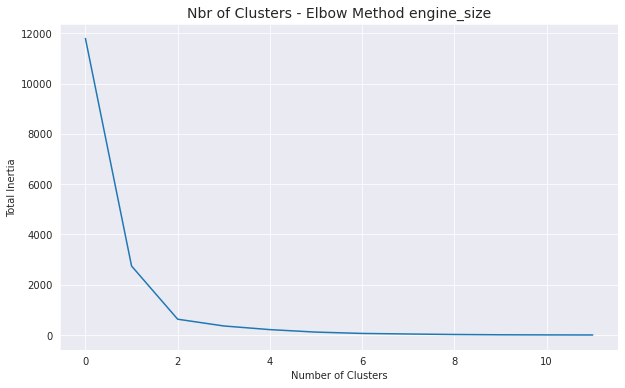

In [21]:
bsp.show_elbow(df['engine_size'].values.reshape(-1, 1),max_iter=12,title='engine_size')

Silhouette score for 2 cluster(s): 0.7145
Silhouette score for 3 cluster(s): 0.8529
Silhouette score for 4 cluster(s): 0.9124
Silhouette score for 5 cluster(s): 0.9157
Silhouette score for 6 cluster(s): 0.9266
Silhouette score for 7 cluster(s): 0.9303
Silhouette score for 8 cluster(s): 0.9677
Silhouette score for 9 cluster(s): 0.9912
Silhouette score for 10 cluster(s): 0.9958
Silhouette score for 11 cluster(s): 0.9961
Silhouette score for 12 cluster(s): 0.9962
Silhouette score for 13 cluster(s): 0.9965
Silhouette score for 14 cluster(s): 0.9971
Silhouette score for 15 cluster(s): 0.9982


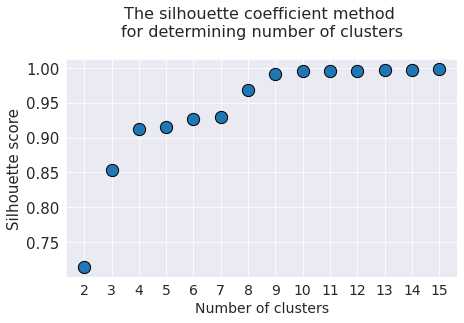

In [60]:
bsp.get_silhouette(df['engine_size'].values.reshape(-1, 1),max_cluster=15, min_cluster = 2,show=True)

#### Nombre de cluster pour `tax`

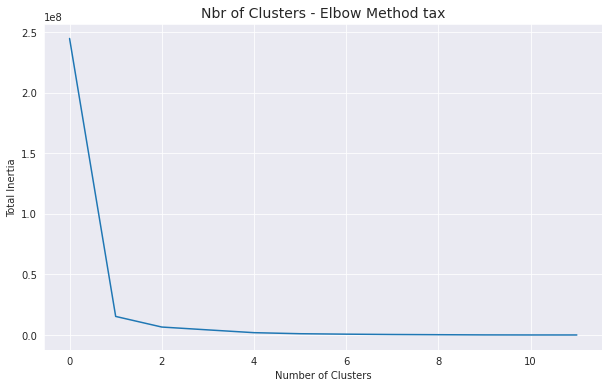

In [22]:
bsp.show_elbow(df['tax'].values.reshape(-1, 1),max_iter=12, title='tax')

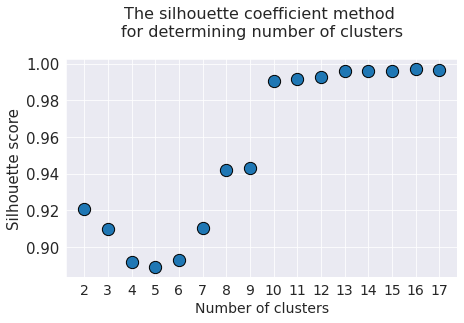

In [24]:
bsp.get_silhouette(df['tax'].values.reshape(-1, 1),max_cluster=17, min_cluster = 2,show=False)

#### Nombre de cluster pour `mpg`

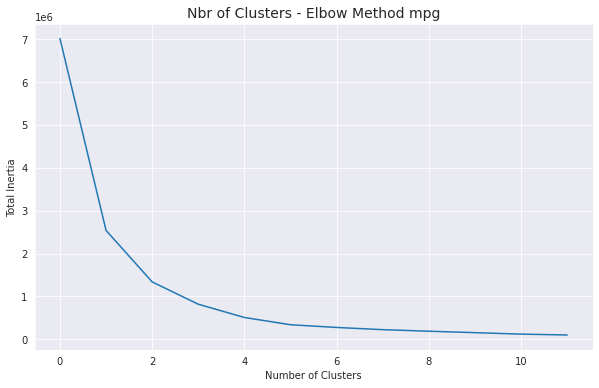

In [23]:
bsp.show_elbow(df['mpg'].values.reshape(-1, 1),max_iter=12,title='mpg')

Silhouette score for 2 cluster(s): 0.5736
Silhouette score for 3 cluster(s): 0.5484
Silhouette score for 4 cluster(s): 0.5586
Silhouette score for 5 cluster(s): 0.5910
Silhouette score for 6 cluster(s): 0.6084
Silhouette score for 7 cluster(s): 0.5806
Silhouette score for 8 cluster(s): 0.5883
Silhouette score for 9 cluster(s): 0.6007
Silhouette score for 10 cluster(s): 0.6194
Silhouette score for 11 cluster(s): 0.6160
Silhouette score for 12 cluster(s): 0.6156
Silhouette score for 13 cluster(s): 0.6429
Silhouette score for 14 cluster(s): 0.6716
Silhouette score for 15 cluster(s): 0.6737


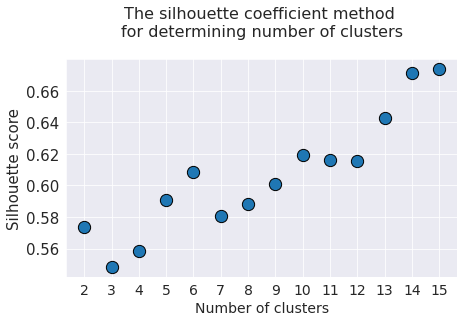

In [59]:
bsp.get_silhouette(df['mpg'].values.reshape(-1, 1),max_cluster=15, min_cluster = 2,show=True)